![nflverse downloads](../images/nfl.png)

#### Goal

Feature Selection:  build features for a play-level model that evaluates the potential a play call (e.g. pass, rush, field goal, etc)  based on the situation and team stats

 - The independent values consist of situations such as drive, down, yards to go seconds reaminign in the game, etc.

- The dependent or "Y" features are simply whether the game was won or lost = WIN/LOSS

- The goal is just to identify the indicators that we'll want to use for subsequent models - this is not an end in itself



#### Input

- nfl_ml_weekly_stats.parquet

#### Steps:

- Extract performance data

- convert ints to float

- measure correlation against the WIN/LOSS target

- Classify important features from XGBoost

- Classify weights from a shallow neural net

- review that they are all in agreement and pick the best from each analysis

- Use SHAP to get the relative weights (importance) for each feature

- Manually separate stats that are offense-related and those that are defence related - for any given drive the offense and defense flip. and we want to be able to provide the stats for whichever team is on offense vs the stats for the opposing team

- take the weighted average of each feature * its weights from SHAP - sum them all up to get a

- this produces a **power_scores** dataset with single offense_power score and defense_power score for each team, for each season and week

- query a version of the **play_actions** table from the database that we'll use to input for a play calling model

- merge the **power_scores** and **play_actions** datasets, so we have the correct offense and defense 'powers' scored for each play, depending on which team is offense and defense.

#### Output

- pbp_actions.parquet
- defense_power.parquet
- offense_power.parquet


# imports

In [21]:
import os
import sys

sys.path.append(os.path.abspath("../src"))

In [22]:
import numpy as np
from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings('ignore')


In [23]:
from src import *

# set flags

In [24]:
DEBUG = False
SCHEMA = 'controls'

# plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">load weekly game statss</h3>
</div>

In [25]:
file_name = get_config('game_stats')
data_directory = get_config('data_directory')
input_path = os.path.join(data_directory, f"{file_name}.parquet")
assert os.path.exists(input_path)

weekly_stats_df = pd.read_parquet(input_path)
stats_df = weekly_stats_df.copy()

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">prepare data</h3>
</div>

### <font color="#9370DB">split into train and test sets</font>
Use 2016 through 2011 seasons to predict the 2022 season

In [26]:

from sklearn.preprocessing import MinMaxScaler

def scale_numeric_columns(df):
    scaler = MinMaxScaler()
    features = scaler.fit_transform(df.to_numpy())
    X = pd.DataFrame(features, columns=df.columns)
    return X

drop_columns = [ 'season', 'week', 'game_id', 'home_team', 'away_team', 'home_final_score' , 'away_final_score']

game_train = stats_df.loc[stats_df['season'] < 2022]
game_test = stats_df.loc[stats_df['season'] == 2022]

X_train = game_train.drop(columns=drop_columns)
y_train = X_train.pop('loss_tie_win')
X_test = game_test.drop(columns=drop_columns)
y_test = X_test.pop('loss_tie_win')

X_train = scale_numeric_columns(X_train)
X_test = scale_numeric_columns(X_test)




<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">create and execute the team-week win/loss models</h3>
</div>

In [27]:
from src.models.team_week_model import create_team_week_model, train_team_week_model

model = create_team_week_model(
    X_train.shape[1],
    regularization_rate=.001,
    activation_function="relu",
    output_function="sigmoid")

r = train_team_week_model(model=model, X=X_train, y=y_train,
                               epochs_size=500,
                               batch_size=32,
                               verbose=0,
                               learning_rate=.001,
                               validation_split=0.25,
                               # validation_data=(X_test, y_test),
                               loss_function='binary_crossentropy')


2023-07-25 12:08:08.863056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-25 12:08:09.432595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">review model performnce</h3>
</div>

### <font color="#9370DB">plot loss</font>

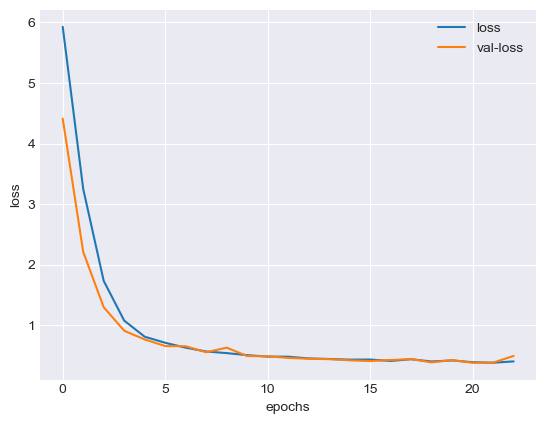

In [28]:

from src.util.utils_eda import plot_loss

plot_loss(r)

### <font color="#9370DB">plot accuracy</font>

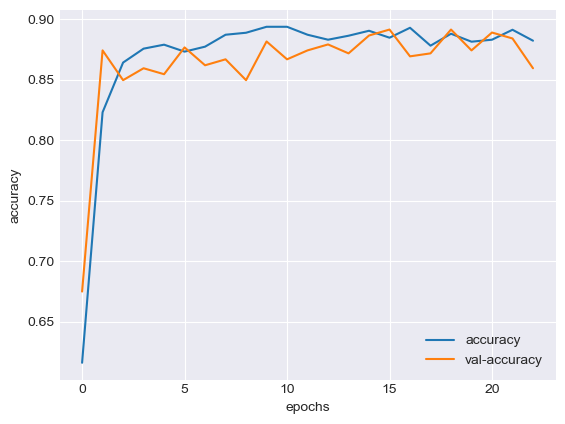

In [29]:
from src.util.utils_eda import plot_accuracy

plot_accuracy(r)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">explain results</h3>
</div>

2023-07-25 12:08:16.803657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


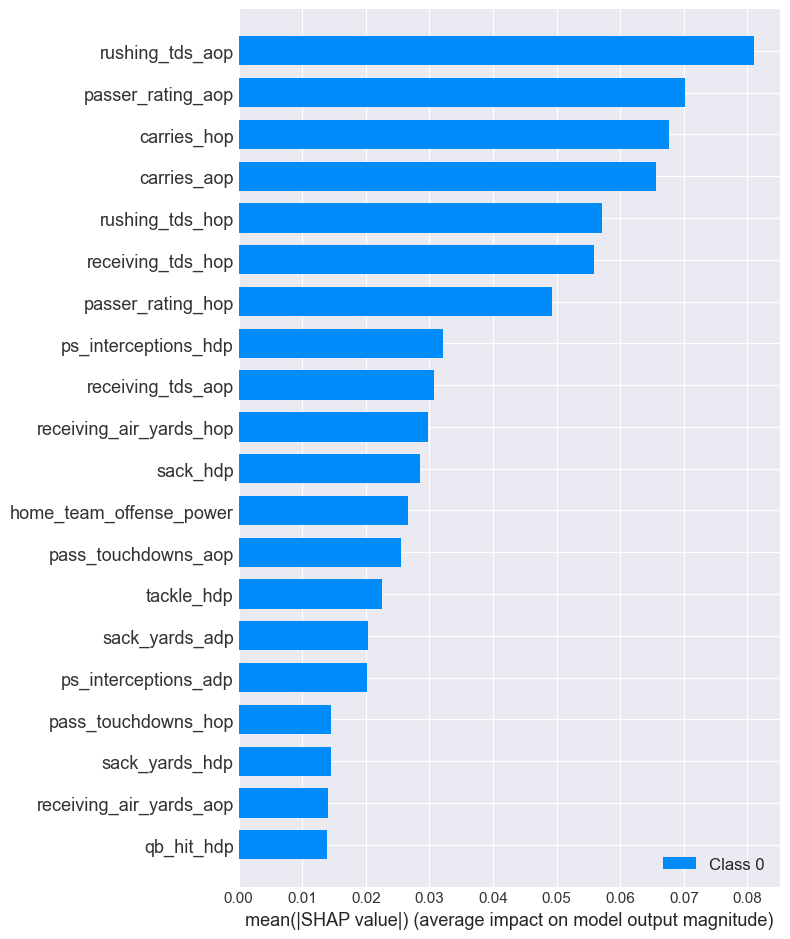

In [30]:
import shap

# Assuming you have a trained Keras model 'model' and a dataset 'X'
explainer = shap.DeepExplainer(model, data=X_train.values)
shap_values = explainer.shap_values(X_train.values)

# save off the explanation so we can review later
game_train_with_shap = pd.concat([game_train['game_id'], pd.DataFrame(shap_values[0], columns=X_train.columns)], axis=1)

# Calculate the mean absolute SHAP values and standard deviations
summary_data = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean': np.abs(shap_values[0]).mean(axis=0)  # Corrected this line to use shap_values[0] directly
})

# Plotting the SHAP values with column names
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">evaluate performance</h3>
</div>

### <font color="#9370DB">precision, recall, f1, auc</font>

In [31]:

threshold = 0.5
y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs >= threshold).astype(int)
count = np.sum(y_pred_probs > 0.5)
print('Count of positive predictions: ', count)

game_test['y_pred_binary'] = y_pred_binary

9/9 [==============================] - 0s 2ms/step
Count of positive predictions:  150


2023-07-25 12:08:27.053551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [32]:
# save off the predictions so we can review them
game_test['y_pred_binary'] = y_pred_binary

In [33]:
from src.util.utils_eda import print_f1_scores
from sklearn.metrics import roc_auc_score

print_f1_scores(y_pred_binary, y_test)



Precision: 0.8933333333333333
Recall: 0.8271604938271605
F1-score: 0.858974358974359


### <font color="#9370DB">ROC /AUC score</font>

AUC:     0.848006476421777


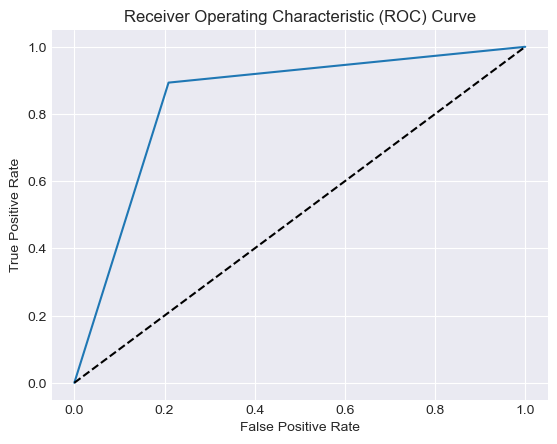

In [34]:
from src.util.util_keras import plot_roc_curve

# Assuming you have y_actual and y_predicted for binary classification
auc = roc_auc_score(y_test, y_pred_binary)
print("AUC:    ", auc)
plot_roc_curve(y_pred_binary, y_test)

### <font color="#9370DB">confusion matrix</font>

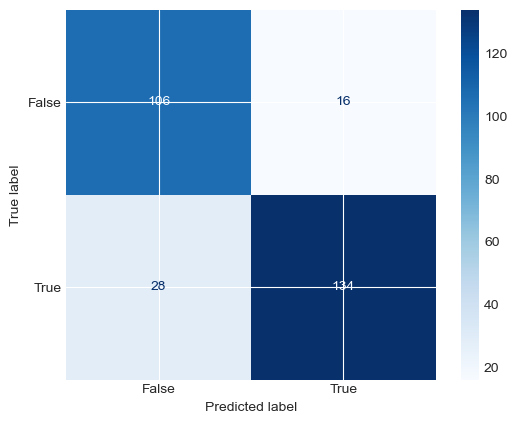

In [35]:
from src.util.utils_eda import plot_confusion_matrix

plot_confusion_matrix(y_pred_binary, y_test)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">save model</h3>
</div>

In [36]:
model_directory = get_config('model_directory')
full_path = os.path.join(model_directory, 'team_week_model.keras')
model.save(full_path)

Save test predictions

In [ ]:
db = DatabaseLoader(get_config('connection_string'))

# Save training explanations
db.load_table(df=game_train, table_name='exp2_shap_scores',schema=get_config('database_schema'))

# Save test predictions
game_test['point_difference'] = game_test['home_final_score'] - game_test['away_final_score'].abs()
game_test['predicted_win_loss'] = game_test['y_pred_binary'].apply(lambda x: 'loss' if x == 0 else 'win/tie')
game_test['model_win_loss'] = game_test.apply( lambda row: 'loss' if row['loss_tie_win'] == 0 else 'win/tie' if row['home_final_score'] == row['away_final_score']  else 'win', axis=1)
game_test['actual_win_loss'] = game_test.apply(lambda row: 'win' if row['home_final_score'] > row['away_final_score'] else 'loss' if row['home_final_score'] < row['away_final_score'] else 'tie', axis=1)
game_test['status'] = game_test.apply(lambda row: 'prediction_error' if row['y_pred_binary'] != row['loss_tie_win'] else 'correct_prediction', axis=1)

game_test['confusion'] = game_test.apply(lambda row:
                                         'FN' if row['status'] == 'prediction_error' and game_test['loss_tie_win'] == 0
                                         else 'FP' if row['status'] == 'prediction_error' and game_test['loss_tie_win'] == 1
                                         else 'TN' if row['status'] == 'correct_prediction' and game_test['loss_tie_win'] == 0
                                         else 'TP' if row['status'] == 'correct_prediction' and game_test['loss_tie_win'] == 1
                                         else 'error', axis=1)
db.load_table(df=game_test, table_name='exp2_game_predictions',schema=get_config('database_schema'))

In [19]:
game_test.groupby(['status']).agg(predictions=('status', 'count'))

,predictions
status,
correct_prediction,242
prediction_error,42
